In [1]:
from Funcs.Utility import *

# Cross-validation

## Implementation

### CV Pipeline

In [2]:
def exclude_low_variance(agg_feature, threshold=.0000001):
    agg_feature_non_zero_var = agg_feature.loc[:,agg_feature.var()>threshold]
    num_removed = agg_feature.shape[1]-agg_feature_non_zero_var.shape[1]
    print(f'{num_removed}/{agg_feature.shape[1]} features with variance < {threshold} removed')
    return agg_feature_non_zero_var

In [3]:
from tqdm import tqdm
def remove_pairwise_corr(agg_feature_percent_missing, PAIRWISE_CORR_THRESHOLD=0.8, outcome_variable=None):
    if outcome_variable is not None:
        outcome_variable = pd.Series(outcome_variable, index=agg_feature_percent_missing.index, name="outcome")
        corr_with_outcome = pd.merge(outcome_variable, agg_feature_percent_missing, left_index=True, right_index=True).corr()[outcome_variable.name].abs().sort_values(ascending=False)
        importance_order = corr_with_outcome.index[1:].tolist()
        agg_feature_percent_missing = agg_feature_percent_missing[importance_order]

    Matrix = agg_feature_percent_missing.corr().abs()
    
    upper_triangle = Matrix.where(np.triu(np.ones(Matrix.shape), k=1).astype(bool))

    correlated_features = set()
    for feature in upper_triangle.columns:
        highly_correlated = upper_triangle[feature][upper_triangle[feature] > PAIRWISE_CORR_THRESHOLD].index
        correlated_features.update(highly_correlated)

    kept_features = list(set(agg_feature_percent_missing.columns) - correlated_features)
    print(f"Pairwise Corr: kept only {len(kept_features)}/{len(agg_feature_percent_missing.columns)} features")
    return agg_feature_percent_missing[kept_features]


In [4]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import LeaveOneGroupOut

class CustomCV:
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def split(self, X, y, groups):
        logo = LeaveOneGroupOut()

        for train_users, test_users in logo.split(X, y, groups):
            X_train_users, X_test_user = X.loc[train_users], X.loc[test_users]
            y_train_users, y_test_user = y[train_users], y[test_users]
            group_train_users, group_test_user = groups[train_users], groups[test_users]

            tscv = TimeSeriesSplit(n_splits=self.n_splits) 

            for train_index, test_index in tscv.split(X_test_user):
                X_train, X_test = pd.concat([X_train_users, X_test_user.iloc[train_index]]), X_test_user.iloc[test_index]
                y_train, y_test = np.concatenate([y_train_users, y_test_user[train_index]]), y_test_user[test_index]

                yield (X_train.index, X_test.index)

In [28]:
import os
import pandas as pd
import numpy as np
import traceback as tb
from contextlib import contextmanager
from typing import Tuple, Dict, Union, Generator, List
from dataclasses import dataclass
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.base import BaseEstimator, clone
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, LeaveOneGroupOut, StratifiedShuffleSplit, RepeatedStratifiedKFold, StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
import time
import ray
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator



@dataclass
class FoldResult:
    name: str
    estimator: BaseEstimator
    X_train: pd.DataFrame
    y_train: np.ndarray
    X_test: pd.DataFrame
    y_test: np.ndarray
    categories: Dict[str, Dict[int, str]] = None
    datetimes_train: np.ndarray = None
    datetimes_test: np.ndarray = None



def _split(
        alg: str,
        X: Union[pd.DataFrame, np.ndarray] = None,
        y: np.ndarray = None,
        groups: np.ndarray = None,
        random_state: int = None,
        n_splits: int = None,
        n_repeats: int = None,
        test_ratio: float = None
) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
    if alg == 'holdout':
        splitter = StratifiedShuffleSplit(
            n_splits=n_splits,
            test_size=test_ratio,
            random_state=random_state
        )
    elif alg == 'kfold':
        if n_repeats and n_repeats > 1:
            splitter = RepeatedStratifiedKFold(
                n_splits=n_splits,
                n_repeats=n_repeats,
                random_state=random_state,
            )
        else:
            splitter = StratifiedKFold(
                n_splits=n_splits,
                random_state=random_state,
                shuffle=False if random_state is None else True,
            )
    elif alg == 'logo':
        splitter = LeaveOneGroupOut()
    elif alg == 'groupk':
        splitter = StratifiedGroupKFold(n_splits=n_splits)
    elif alg == 'TimeSeriesSplit':
        splitter = TimeSeriesSplit(n_splits=n_splits)
    elif alg == 'custom_cv':
        splitter = CustomCV(n_splits=n_splits)
        
    else:
        raise ValueError('"alg" should be one of "holdout", "kfold", "logo", "TimeSeriesSplit", "custom_cv" or "groupk".')

    split = splitter.split(X, y, groups)

    for I_train, I_test in split:
        yield I_train, I_test


def _train(
    dir_result: str,
    name: str,
    datetimes_train: np.ndarray,  # Add datetimes_train parameter
    datetimes_test: np.ndarray,  # Add datetimes_test parameter

    X_train: pd.DataFrame,
    y_train: np.ndarray,
    X_test: pd.DataFrame,
    y_test: np.ndarray,
    C_cat: np.ndarray,
    C_num: np.ndarray,
    estimator: BaseEstimator,
    normalize: bool = False,
    select: Union[List[SelectFromModel], SelectFromModel] = None,
    oversample: bool = False,
    random_state: int = None,
    categories: Union[List, Dict[str, Dict[int, str]]] = None


):
    @contextmanager
    def _log(task_type: str):
        log(f'In progress: {task_type}.')
        _t = time.time()
        _err = None
        _result = dict()
        
        try:
            yield _result
        except:
            _err = tb.format_exc()
        finally:
            _e = time.time() - _t
            if _err:
                _msg = f'Failure: {task_type} ({_e:.2f}s). Keep running without this task. Caused by: \n{_err}' 
            else:
                _msg = f'Success: {task_type} ({_e:.2f}s).' 
                if _result:
                    _r = '\n'.join([f'- {k}: {v}' for k, v in _result.items()])
                    _msg = f'{_msg}\n{_r}'
            log(_msg)
    
    if normalize:
        with _log(f'[{name}] Normalizing numeric features'):
            X_train_N, X_test_N = X_train[C_num].values, X_test[C_num].values
            X_train_C, X_test_C = X_train[C_cat].values, X_test[C_cat].values
            
            scaler = StandardScaler().fit(X_train_N)
            X_train_N = scaler.transform(X_train_N)
            X_test_N = scaler.transform(X_test_N)
         
            X_train = pd.DataFrame(
                np.concatenate((X_train_C, X_train_N), axis=1),
                columns=np.concatenate((C_cat, C_num))
            )
            X_test = pd.DataFrame(
                np.concatenate((X_test_C, X_test_N), axis=1),
                columns=np.concatenate((C_cat, C_num))
            )
           
    if select:
#         # Removing low variance features
#         X_train = exclude_low_variance(X_train)
#         X_test = X_test[X_train.columns]  # Keep only the selected features in the test set

#         # Removing highly correlated features
#         X_train = remove_pairwise_corr(X_train, outcome_variable= y_train)
#         X_test = X_test[X_train.columns]  # Keep only the selected features in the test set

        if isinstance(select, SelectFromModel):
            select = [select]
            
        for i, s in enumerate(select):
            with _log(f'[{name}] {i+1}-th Feature selection') as r:
                C = np.asarray(X_train.columns)
                r['# Orig. Feat.'] = f'{len(C)} (# Cat. = {len(C_cat)}; # Num. = {len(C_num)})'
                M = s.fit(X=X_train.values, y=y_train).get_support()
                C_sel = C[M]
                C_cat = C_cat[np.isin(C_cat, C_sel)]
                C_num = C_num[np.isin(C_num, C_sel)]
                
                X_train_N, X_test_N = X_train[C_num].values, X_test[C_num].values
                X_train_C, X_test_C = X_train[C_cat].values, X_test[C_cat].values


                X_train = pd.DataFrame(
                    np.concatenate((X_train_C, X_train_N), axis=1),
                    columns=np.concatenate((C_cat, C_num))
                )
                X_test = pd.DataFrame(
                    np.concatenate((X_test_C, X_test_N), axis=1),
                    columns=np.concatenate((C_cat, C_num))
                )
                r['# Sel. Feat.'] = f'{len(C_sel)} (# Cat. = {len(C_cat)}; # Num. = {len(C_num)})'

    if oversample:
        with _log(f'[{name}] Oversampling') as r:
            if len(C_cat):
                M = np.isin(X_train.columns, C_cat)
                sampler = SMOTENC(categorical_features=M, random_state=random_state)
            else:
                sampler = SMOTE(random_state=random_state)
            X_train, y_train = sampler.fit_resample(X_train, y_train)
#             # Create oversampled datetimes_train
#             datetimes_train_oversampled = np.repeat(datetimes_train, sampler.sample_indices_.shape[0], axis=0)

    # You can access the underlying model class like this:
    if isinstance(estimator, LSTMWrapper):
        with _log(f'[{name}] Training LSTM'):
            
            lstm_model = estimator  # Already an instance of LSTMModel
            lstm_model.fit(X_train, y_train, datetimes_train)  # datetimes_train added
            result = FoldResult(
                name=name,
                estimator=lstm_model,
                X_train=X_train,
                y_train=y_train,
                X_test=X_test,
                y_test=y_test,
                categories=categories,
                datetimes_train=datetimes_train,

                datetimes_test=datetimes_test
            )
            dump(result, os.path.join(dir_result, f'{name}.pkl'))

    else:
        with _log(f'[{name}] Training'):
            estimator = estimator.fit(X_train, y_train)
            result = FoldResult(
                name=name,
                estimator=estimator,
                X_train=X_train,
                y_train=y_train,
                X_test=X_test,
                y_test=y_test,
                categories=categories
            )
            dump(result, os.path.join(dir_result, f'{name}.pkl'))
    

def cross_val(
    X: pd.DataFrame,
    y: np.ndarray,
    groups: np.ndarray,
    datetimes:  np.ndarray,
    path: str,
    name: str,
    estimator: BaseEstimator,
    categories: List[str] = None,
    normalize: bool = False,
    split: str = None,
    split_params: Dict[str, any] = None,
    select: Union[List[SelectFromModel], SelectFromModel] = None,
    oversample: bool = False,
    random_state: int = None,
    lookback: int = 1  # Add the `lookback` parameter here

):
    if not os.path.exists(path):
        raise ValueError('"path" does not exist.')
    
    if not split:
        raise ValueError('"split" should be specified.')
    
    if not ray.is_initialized():
        raise EnvironmentError('"ray" should be initialized.')
    
    jobs = []
    func = ray.remote(_train).remote

    categories = list() if categories is None else categories
    C_cat = np.asarray(sorted(categories))
    C_num = np.asarray(sorted(X.columns[~X.columns.isin(C_cat)]))

    split_params = split_params or dict()
    splitter = _split(alg=split, X=X, y=y, groups=groups, random_state=random_state, **split_params)
    
    # You can access the underlying model class like this:
    if isinstance(estimator, LSTMWrapper):
        estimator.set_params(lookback=lookback)
    

    for idx_fold, (I_train, I_test) in enumerate(splitter):
        if split == 'logo':
            FOLD_NAME = str(np.unique(groups[I_test]).item(0))
        else:
            FOLD_NAME = str(idx_fold + 1)

        X_train, y_train = X.iloc[I_train, :], y[I_train]
        X_test, y_test = X.iloc[I_test, :], y[I_test]
        datetimes_train, datetimes_test = datetimes[I_train], datetimes[I_test]  # Add datetimes_train and datetimes_test


        job = func(
            dir_result=path,
            
            datetimes_train=datetimes_train,  # Pass datetimes_train
            datetimes_test=datetimes_test,  # Pass datetimes_test

            name=f'{name}#{FOLD_NAME}',
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            C_cat=C_cat,
            C_num=C_num,
            categories=categories,
            estimator=clone(estimator),
            normalize=normalize,
            select=select,
            oversample=oversample,
            random_state=random_state

        )
        jobs.append(job)
    ray.get(jobs)

### Minor Modification on XGBClassifer
This modification allows XGBClassifiers to automatically generate evaluation sets during pipeline (without passing any argument in "fit" function)

In [29]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedShuffleSplit
from typing import Union


class EvXGBClassifier(BaseEstimator):
    def __init__(
        self,
        eval_size=None,
        eval_metric='logloss',
        early_stopping_rounds=10,
        random_state=None,
        **kwargs
        ):
        self.random_state = random_state
        self.eval_size = eval_size
        self.eval_metric = eval_metric
        self.early_stopping_rounds = early_stopping_rounds
        self.model = XGBClassifier(
            random_state=self.random_state,
            eval_metric=self.eval_metric,
            early_stopping_rounds=self.early_stopping_rounds,
            **kwargs
        )

    @property
    def classes_(self):
        return self.model.classes_

    @property
    def feature_importances_(self):
        return self.model.feature_importances_
    
    @property
    def feature_names_in_(self):
        return self.model.feature_names_in_

    def fit(self, X: Union[pd.DataFrame, np.ndarray], y: np.ndarray):
        if self.eval_size:
            splitter = StratifiedShuffleSplit(random_state=self.random_state, test_size=self.eval_size)
            I_train, I_eval = next(splitter.split(X, y))
            if isinstance(X, pd.DataFrame):
                X_train, y_train = X.iloc[I_train, :], y[I_train]
                X_eval, y_eval = X.iloc[I_eval, :], y[I_eval]
            else:
                X_train, y_train = X[I_train, :], y[I_train]
                X_eval, y_eval = X[I_eval, :], y[I_eval]
                
            self.model = self.model.fit(
                X=X_train, y=y_train, 
                eval_set=[(X_eval, y_eval)],
                verbose=False
            )
        else:
            self.model = self.model.fit(X=X, y=y, verbose=False)
        return self

    def predict(self, X: pd.DataFrame):
        return self.model.predict(X)

    def predict_proba(self, X: pd.DataFrame):
        return self.model.predict_proba(X)

In [30]:
from typing import Union
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


class LSTMWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, lookback=1, batch_size=32):
        self.lookback = lookback
        self.batch_size = batch_size
        self.model = None

    def _preprocess(self, X: Union[pd.DataFrame, np.ndarray], y: np.ndarray, datetimes: np.ndarray):
        datetimes = datetimes.reshape(-1, 1)
        time_delta = np.diff(datetimes, axis=0)
        time_delta = np.concatenate([np.array([[0]]), time_delta])

        if isinstance(X, pd.DataFrame):
            X = X.values

        X_with_time_delta = np.concatenate((X, time_delta), axis=1)

        scaler = MinMaxScaler(feature_range=(0, 1))
        X_scaled = scaler.fit_transform(X_with_time_delta)

        data_gen = TimeseriesGenerator(
            X_scaled, y if y is not None else np.zeros(len(X)),
            length=self.lookback,
            sampling_rate=1,
            stride=1,
            batch_size=self.batch_size,
        )

        if y is not None:
            y_with_time_delta = np.concatenate((y.reshape(-1, 1), np.zeros((len(y), self.lookback - 1))), axis=1)
            y_scaled = scaler.fit_transform(y_with_time_delta)

            data_gen_y = TimeseriesGenerator(
                y_scaled,
                y_scaled,
                length=self.lookback,
                sampling_rate=1,
                stride=1,
                batch_size=self.batch_size,
            )
            return iter(data_gen), iter(data_gen_y)

        return iter(data_gen)


    def fit(self, X, y, datetimes):
        X_train_gen, y_train_gen = self._preprocess(X, y, datetimes)
        
        X_train_batch, y_train_batch = next(X_train_gen), next(y_train_gen)
        X_train_shape = X_train_batch[0].shape

        self.model = Sequential()
        self.model.add(LSTM(64, input_shape=(self.lookback, X_train_shape[-1])))
        self.model.add(Dense(1, activation='sigmoid'))  # sigmoid activation added
        self.model.compile(loss='binary_crossentropy', optimizer='adam')  # change loss to binary_crossentropy

        # Loop through all batches and fit the model on each batch
        for X_batch, y_batch in zip(X_train_gen, y_train_gen):
            self.model.fit(X_batch[0], y_batch[0], epochs=5, batch_size=self.batch_size)


    def predict(self, X, datetimes):
        X_test_gen = self._preprocess(X, None, datetimes)
        if X_test_gen is None:
            return np.zeros(len(X))  # Return an array of zeros with the same length as X when X_test_gen is None

        # Loop through all batches and make predictions on each batch
        y_pred = []
        for X_batch in X_test_gen:
            # Reshape input data to have shape (batch_size, lookback, n_features)
#             X_test_shape = X_batch[0].shape
#             X_reshaped = X_batch[0].reshape((X_test_shape[0], self.lookback, X_test_shape[-1]))
            y_pred.append(self.model.predict(X_batch[0]))
        return np.concatenate(y_pred)


    
    def get_params(self, deep=True):
        return {"lookback": self.lookback}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


## Execution

In [8]:
# LABELS_PROC = pd.read_csv(os.path.join(PATH_INTERMEDIATE, 'proc', 'LABELS_PROC.csv'), index_col=['pcode','timestamp'],parse_dates=True)

In [9]:
#Use user speicifc mean threshold

# LABELS_PROC['stress_user_mean'] = np.nan

# for user in LABELS_PROC.index.get_level_values('pcode').unique():
#     user_df = LABELS_PROC.loc[user].copy()
#     user_mean = user_df['stress'].mean()
#     user_df['stress_user_mean'] = user_df['stress'].apply(lambda x: 1 if x > user_mean else 0)
#     LABELS_PROC.loc[user, 'stress_user_mean'] = user_df['stress_user_mean'].to_list()


In [103]:
import os
from itertools import product
from sklearn.base import clone
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from eli5.sklearn.permutation_importance import PermutationImportance
import numpy as np



RANDOM_STATE = 42
lookback = 1

ESTIMATOR_DUMMY = DummyClassifier(strategy='prior')
ESTIMATOR_RF = RandomForestClassifier(random_state=RANDOM_STATE)
ESTIMATOR_XGB = EvXGBClassifier(
    random_state=RANDOM_STATE, 
    eval_metric='logloss', 
    eval_size=0.2,
    early_stopping_rounds=10, 
    objective='binary:logistic', 
    verbosity=0,
    learning_rate=0.01
)
ESTIMATOR_LR = LogisticRegression(random_state = RANDOM_STATE, max_iter=500 )
ESTIMATOR_KNN = KNeighborsClassifier()
ESTIMATOR_SVM = SVC(probability=True)
ESTIMATOR_GP = GaussianProcessClassifier(random_state=RANDOM_STATE)
ESTIMATOR_DT = DecisionTreeClassifier(random_state = RANDOM_STATE)
ESTIMATOR_MLP = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000)
ESTIMATOR_ADAB = AdaBoostClassifier(random_state=RANDOM_STATE)
ESTIMATOR_GNB = GaussianNB()
ESTIMATOR_QDA = QuadraticDiscriminantAnalysis()
ESTIMATOR_LSTM = LSTMWrapper()

  

SELECT_SVC = SelectFromModel(
    estimator=LinearSVC(
        penalty='l1',
        loss='squared_hinge',
        dual=False,
        tol=1e-3,
        C=1e-2,
        max_iter=5000,
        random_state=RANDOM_STATE
    ),
    
#         estimator=LogisticRegression(
#         penalty='l1' 
#         ,solver='liblinear'
#         , C=1, random_state=RANDOM_STATE, max_iter=4000
#     ),
    threshold=1e-5
#     threshold = 0.005
)

# CLS = ['valence', 'arousal', 'stress', 'disturbance']
CLS = ['stress']

SETTINGS = [
    dict(
        estimator=clone(ESTIMATOR_DUMMY),
        oversample=False,
        select=None,
        name='dummy'
    ),
    dict(
        estimator=clone(ESTIMATOR_RF),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='rf_os'
    ),
    dict(
        estimator=clone(ESTIMATOR_XGB),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='xgb_os'
    ),
    dict(
        estimator=clone(ESTIMATOR_LR),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='lr_os'
    ),
    dict(
        estimator=clone(ESTIMATOR_KNN),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='knn_os'
    ),
    dict(
        estimator=clone(ESTIMATOR_SVM),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='svm_os'
    ),
#     dict(
#         estimator=clone(ESTIMATOR_DT),
#         oversample=True,
#         select=[clone(SELECT_SVC)],
#         name='dt_os'
#     ),
    dict(
        estimator=clone(ESTIMATOR_MLP),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='mlp_os'
    ),
    dict(
        estimator=clone(ESTIMATOR_ADAB),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='adab_os'
    ),
#         dict(
#         estimator=clone(ESTIMATOR_GP),
#         oversample=True,
#         select=[clone(SELECT_SVC)],
#         name='gp_os'
#     ),
#             dict(
#         estimator=clone(ESTIMATOR_GNB),
#         oversample=True,
#         select=[clone(SELECT_SVC)],
#         name='gnb_os'
#     ),
#             dict(
#         estimator=clone(ESTIMATOR_QDA),
#         oversample=True,
#         select=[clone(SELECT_SVC)],
#         name='qda_os'
#     ),
#     dict(
#         estimator=clone(ESTIMATOR_LSTM),
#         oversample=None,
#         lookback=lookback,
#         select=[clone(SELECT_SVC)],
#         name='lstm_os'
#     )
]



p = os.path.join(PATH_INTERMEDIATE, 'feat',f'stress.pkl')
par_dir = os.path.join(PATH_INTERMEDIATE, 'eval', 'stress')

if os.path.isdir(par_dir):
    # Get a list of all the files in the folder
    files = os.listdir(par_dir)

    # Delete all the files in the folder
    for file in files:
        if file !='.ipynb_checkpoints':
            os.remove(os.path.join(par_dir, file))
os.makedirs(par_dir, exist_ok=True)

#with on_ray(num_cpus=6):
with on_ray():
    for l, s in product(
        CLS, SETTINGS
    ):       
        X, y, groups, t, datetimes = load(p)
        ################################################
        #Use user speicifc mean threshold
#         y =LABELS_PROC['stress_user_mean'].to_numpy()
        #Use fixed threshold
#         y =LABELS_PROC['stress_fixed'].to_numpy()
        #Use three categories (fixed threshold)
#        y =LABELS_PROC['stress_fixed_tri'].to_numpy()

        
        #The following code is designed for reordering for the sake of time series split
        #################################################
        # Create a DataFrame with user_id and datetime
        df = pd.DataFrame({'user_id': groups, 'datetime': pd.to_datetime(datetimes)})

        # Normalize the datetime for each user
#         df['datetime'] = df.groupby('user_id')['datetime'].transform(lambda x: x - x.min())
        df['datetime'] = df.groupby('user_id')['datetime'].transform(lambda x: x - x.min().normalize())

        # Sort the DataFrame by datetime
#         df = df.sort_values(by=['user_id', 'datetime'])
        df = df.sort_values(by=[ 'datetime'])
        # Shuffle the DataFrame
#         df = df.sample(frac=1, random_state=RANDOM_STATE)

        # Update groups and datetimes
        groups = df['user_id'].to_numpy()
        datetimes = df['datetime'].dt.total_seconds().to_numpy()  # convert to seconds

        # Use the new order to reorder X and y
        X = X.reindex(df.index)
        y = y[df.index]
#         ###################################################
        

        #The following code is for only using 1st day
        ###########################################
#         filtered_df = pd.read_csv(os.path.join(PATH_INTERMEDIATE,'exclude_1st_day.csv'),index_col=0)
#         X_filtered = X[~X.index.isin(filtered_df.index)]
#         y_series = pd.Series(y, index=X.index)
#         y_filtered = y_series[~y_series.index.isin(filtered_df.index)]
#         y_filtered = y_filtered.values
#         groups_series = pd.Series(groups, index=X.index)
#         groups_filtered = groups_series[~groups_series.index.isin(filtered_df.index)]
#         groups_filtered = groups_filtered.values
#         X,y, groups=X_filtered,y_filtered, groups_filtered
        #The following code is for excluding using 1st day
        ###########################################
#         filtered_df = pd.read_csv(os.path.join(PATH_INTERMEDIATE,'exclude_1st_day.csv'),index_col=0)
#         X_filtered = X[X.index.isin(filtered_df.index)]
#         y_series = pd.Series(y, index=X.index)
#         y_filtered = y_series[y_series.index.isin(filtered_df.index)]
#         y_filtered = y_filtered.values
#         groups_series = pd.Series(groups, index=X.index)
#         groups_filtered = groups_series[groups_series.index.isin(filtered_df.index)]
#         groups_filtered = groups_filtered.values
#         X,y, groups=X_filtered,y_filtered, groups_filtered
        
        
        ###########################################
        #The following code is for similar-user model
        ###########################################
#         similar_user = pd.read_csv(os.path.join(PATH_INTERMEDIATE,  'similar_user.csv'))
#         cluster_label = similar_user['cluster'].value_counts().index[0] #N number clusters
#         similar_users_in_cluster = similar_user[similar_user['cluster'] == cluster_label]['pcode']

#         # Check if each value in 'groups' is in 'similar_users_in_cluster'
#         mask = np.isin(groups, similar_users_in_cluster)

#         # Filter 'groups' based on the mask
#         filtered_groups = groups[mask]
#         # Filter 'X' and 'y' based on the mask
#         X_filtered = X[mask]
#         y_filtered = y[mask]
#         X,y, groups=X_filtered,y_filtered, filtered_groups
        ###########################################
        #Remove low frequency features
#         mask = ['CAE#', 'MED#', 'ONF#', 'PWS#', 'RNG#','MSG#' ]
#         X = X.loc[:, [all(m not in str(x) for m in mask) for x in X.columns]]

        #Divide the features into different categories
        feat_current = X.loc[:,[('#VAL' in str(x)) or ('ESM#LastLabel' in str(x)) for x in X.keys()]]  
        feat_dsc = X.loc[:,[('#DSC' in str(x))  for x in X.keys()]]  
        feat_yesterday = X.loc[:,[('Yesterday' in str(x))  for x in X.keys()]]  
        feat_today = X.loc[:,[('Today' in str(x))  for x in X.keys()]]  
        feat_sleep = X.loc[:,[('Sleep' in str(x))  for x in X.keys()]]  
        feat_time = X.loc[:,[('Time' in str(x))  for x in X.keys()]]  
        feat_pif = X.loc[:,[('PIF' in str(x))  for x in X.keys()]]  
        feat_ImmediatePast = X.loc[:,[('ImmediatePast' in str(x))  for x in X.keys()]]
        #Divide the time window features into sensor/past stress label
        feat_current_sensor = X.loc[:,[('#VAL' in str(x))  for x in X.keys()]]  
        feat_current_ESM = X.loc[:,[('ESM#LastLabel' in str(x)) for x in X.keys()]]  
        feat_ImmediatePast_sensor = feat_ImmediatePast.loc[:,[('ESM' not in str(x)) for x in feat_ImmediatePast.keys()]]  
        feat_ImmediatePast_ESM = feat_ImmediatePast.loc[:,[('ESM'  in str(x)) for x in feat_ImmediatePast.keys()]]  
        feat_today_sensor = feat_today.loc[:,[('ESM' not in str(x))  for x in feat_today.keys()]]  
        feat_today_ESM = feat_today.loc[:,[('ESM'  in str(x)) for x in feat_today.keys()]]  
        feat_yesterday_sensor = feat_yesterday.loc[:,[('ESM' not in str(x)) for x in feat_yesterday.keys()]]  
        feat_yesterday_ESM = feat_yesterday.loc[:,[('ESM'  in str(x)) for x in feat_yesterday.keys()]]  
        #Prepare the final feature set
        feat_baseline = pd.concat([ feat_pif, feat_time,feat_dsc,feat_current_sensor, feat_ImmediatePast_sensor],axis=1)
        #The following code is for calculating aggregated features
        ########################################################################
        # Define a function to split the column name into sensor and attribute
#         def split_column_name(col_name):
#             parts = col_name.rsplit("#", 1)  # Split on last occurrence of '#'
#             return parts[0]  # This gives you 'Sensor#Attribute'

#         # Get a list of unique sensor-attribute combinations
#         df=feat_today_sensor
#         sensor_attributes = df.columns.map(split_column_name).unique()

#         # Create a list to hold the aggregated results
#         agg_results = []

#         # Loop over each sensor-attribute, select the appropriate columns, compute the mean and std
#         for sensor_attribute in sensor_attributes:
#             # Select columns for this sensor-attribute
#             cols_to_aggregate = [col for col in df.columns if col.startswith(sensor_attribute)]
#             # Compute the mean and std and store in the new DataFrame
#             agg_results.append(df[cols_to_aggregate].mean(axis=1).rename(sensor_attribute + '|'+ 'MEAN'))
#             agg_results.append(df[cols_to_aggregate].std(axis=1).rename(sensor_attribute + '|'+'STD'))

#         # Concatenate all the results into a single DataFrame
#         agg_feature = pd.concat(agg_results, axis=1)
        #########################################################################
        feat_final = pd.concat([    feat_yesterday_ESM],axis=1)
        X = feat_final
        
        cats = X.columns[X.dtypes == bool]
        
        cross_val(
            X=X, y=y, groups=groups, datetimes =datetimes,
            path=par_dir,
            normalize=True,
            split='groupk',
            categories=cats,
            split_params={'n_splits' : 5},
            random_state=RANDOM_STATE,

            **s
        )

2023-06-12 10:56:27,527	INFO worker.py:1432 -- Connecting to existing Ray cluster at address: 192.168.1.28:6379...
2023-06-12 10:56:27,541	INFO worker.py:1616 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
(pid=1608776) 2023-06-12 10:56:28.621934: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=1608776) 2023-06-12 10:56:28.623830: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=1608776) 2023-06-12 10:56:28.659027: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=1608776) 2023-06-12 10:56:28.659510: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions i

(_train pid=1608776) [23-06-12 10:56:29] In progress: [dummy#1] Normalizing numeric features.
(_train pid=1608776) [23-06-12 10:56:29] Success: [dummy#1] Normalizing numeric features (0.00s).
(_train pid=1608776) [23-06-12 10:56:29] In progress: [dummy#1] Training.
(_train pid=1608776) [23-06-12 10:56:29] Success: [dummy#1] Training (0.05s).
(_train pid=1608776) [23-06-12 10:56:30] In progress: [rf_os#5] 1-th Feature selection.
(_train pid=1608776) [23-06-12 10:56:30] Success: [rf_os#5] 1-th Feature selection (0.01s).
(_train pid=1608776) - # Orig. Feat.: 6 (# Cat. = 0; # Num. = 6)
(_train pid=1608776) - # Sel. Feat.: 4 (# Cat. = 0; # Num. = 4)
(_train pid=1608776) [23-06-12 10:56:30] In progress: [rf_os#5] Oversampling.
(_train pid=1608776) [23-06-12 10:56:30] Success: [rf_os#5] Oversampling (0.01s).
(_train pid=1608776) [23-06-12 10:56:34] In progress: [mlp_os#2] Normalizing numeric features. [repeated 30x across cluster]
(_train pid=1608776) [23-06-12 10:56:34] Success: [mlp_os#2] N

(pid=1609155) 2023-06-12 10:56:29.146161: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 4x across cluster]
(pid=1609155) 2023-06-12 10:56:29.183225: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used. [repeated 8x across cluster]
(pid=1609155) 2023-06-12 10:56:29.183701: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations. [repeated 4x across cluster]
(pid=1609155) To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags. [repeated 4x across cluster]
(pid=1609155) 2023-06-12 10:56:29.769348: W tensorflow/compiler/tf

Autocorrelation

In [87]:
# Calculate the Pearson correlation coefficient
r = np.corrcoef(feat_current_ESM['ESM#LastLabel_3'], y)[0, 1]

In [89]:
 r

0.3218427521099164

# Evaluation

## Implementation

In [104]:
import numpy as np
from typing import Dict
from itertools import product
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, balanced_accuracy_score, \
    confusion_matrix, precision_recall_fscore_support, \
    roc_auc_score, matthews_corrcoef, average_precision_score, \
    log_loss, brier_score_loss
import scipy.stats.mstats as ms


def evaluate(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    y_prob: np.ndarray,
    classes: np.ndarray
) -> Dict[str, any]:

    R = {}
    n_classes = len(classes)
    is_multiclass = n_classes > 2
    is_same_y = len(np.unique(y_true)) == 1
    R['inst'] = len(y_true)
    
    for c in classes:
        R[f'inst_{c}'] = np.sum(y_true == c)
        
    if not is_multiclass:
        _, cnt = np.unique(y_true, return_counts=True)
        
        if len(cnt) > 1:
            R['class_ratio'] = cnt[0] / cnt[1]
        else:
            R['class_ratio'] = np.nan

    C = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=classes)
    for (i1, c1), (i2, c2) in product(enumerate(classes), enumerate(classes)):
        R[f'true_{c1}_pred_{c2}'] = C[i1, i2]

    # Threshold Measure
    R['acc'] = accuracy_score(y_true=y_true, y_pred=y_pred)
    R['bac'] = balanced_accuracy_score(y_true=y_true, y_pred=y_pred)
    R['gmean'] = ms.gmean(np.diag(C) / np.sum(C, axis=1))
    R['mcc'] = matthews_corrcoef(y_true=y_true, y_pred=y_pred)
    
    if is_multiclass:
        for avg in ('macro', 'micro'):
            pre, rec, f1, _ = precision_recall_fscore_support(
                y_true=y_true,
                y_pred=y_pred,
                labels=classes,
                average=avg, 
                zero_division=0
            )
            R[f'pre_{avg}'] = pre
            R[f'rec_{avg}'] = rec
            R[f'f1_{avg}'] = f1
    else:
        pre, rec, f1, _ = precision_recall_fscore_support(
            y_true=y_true, y_pred=y_pred, pos_label=c, average='macro', zero_division=0
        )
        R[f'pre_macro'] = pre
        R[f'rec_macro'] = rec
        R[f'f1_macro'] = f1
        
        for c in classes:
            pre, rec, f1, _ = precision_recall_fscore_support(
                y_true=y_true, y_pred=y_pred, pos_label=c, average='binary', zero_division=0
            )
            R[f'pre_{c}'] = pre
            R[f'rec_{c}'] = rec
            R[f'f1_{c}'] = f1



    # ...

    # Ranking Measure
    if is_multiclass:
        if y_prob is not None:
            for avg, mc in product(('macro', 'micro'), ('ovr', 'ovo')):
                R[f'roauc_{avg}_{mc}'] = roc_auc_score(
                    y_true=y_true, y_score=y_prob,
                    average=avg, multi_class=mc, labels=classes
                ) if not is_same_y else np.nan
        else:
            for avg, mc in product(('macro', 'micro'), ('ovr', 'ovo')):
                R[f'roauc_{avg}_{mc}'] = np.nan
    else:
        if y_prob is not None:
            R[f'roauc'] = roc_auc_score(
                y_true=y_true, y_score=y_prob[:, 1], average=None
            ) if not is_same_y else np.nan
            for i, c in enumerate(classes):
                R[f'prauc_{c}'] = average_precision_score(
                    y_true=y_true, y_score=y_prob[:, i], pos_label=c, average=None
                ) 
                R[f'prauc_ref_{c}'] = np.sum(y_true == c) / len(y_true)
        else:
            R[f'roauc'] = np.nan
            for c in classes:
                R[f'prauc_{c}'] = np.nan
                R[f'prauc_ref_{c}'] = np.nan

    # Probability Measure
    if y_prob is not None:
        R['log_loss'] = log_loss(y_true=y_true, y_pred=y_prob, labels=classes, normalize=True)
        if not is_multiclass:
            R[f'brier_loss'] = brier_score_loss(
                y_true=y_true, y_prob=y_prob[:, 1], pos_label=classes[1]
            )
    else:
        R['log_loss'] = np.nan
        if not is_multiclass:
            R[f'brier_loss'] = np.nan

    return R


## Execution

In [105]:
import os
import pandas as pd

RESULTS_EVAL = []
DIR_EVAL = os.path.join(PATH_INTERMEDIATE, 'eval')
threshold = 0.5

# Loop through the desired labels
for l in ['stress']:
    dir_l = os.path.join(DIR_EVAL, l)
    if not os.path.exists(dir_l):
        continue

    for f in os.listdir(dir_l):
        if f == '.ipynb_checkpoints':
            continue

        model, pid = f[:f.index('.pkl')].split('#')
        res = load(os.path.join(dir_l, f))
        X, y = res.X_test, res.y_test

        # Check if the classifier is LSTM-based
        if isinstance(res.estimator, LSTMWrapper) or res.estimator.__class__.__name__ == "LSTMWrapper":
            # Extract datetimes and perform predictions
            datetimes = res.datetimes_test
            y_prob = res.estimator.predict(X, datetimes)
            y_pred = np.where(y_prob > threshold, 1, 0)
            
            
            y = y[lookback:]

            
            # Transform y_prob into a two-dimensional array with two columns
            row_numbers = np.arange(len(y_prob))
            y_prob = np.column_stack((row_numbers, y_prob))



        else:
            # Perform predictions for other classifiers (without datetimes)
            y_pred = res.estimator.predict(X)

            if hasattr(res.estimator, 'predict_proba'):
                y_prob = res.estimator.predict_proba(X)
            else:
                y_prob = None

        ev_test = evaluate(
            y_true=y,
            y_pred=y_pred,
            y_prob=y_prob,
            classes=[0, 1]
        )

        X, y = res.X_train, res.y_train

        # Check if the classifier is LSTM-based
        if isinstance(res.estimator, LSTMWrapper) or res.estimator.__class__.__name__ == "LSTMWrapper":
            # Extract datetimes and perform predictions
            datetimes = res.datetimes_train
            y_prob = res.estimator.predict(X, datetimes)
            y_pred = np.where(y_prob > threshold, 1, 0)
            
            y = y[lookback:]

            
            # Transform y_prob into a two-dimensional array with two columns
            row_numbers = np.arange(len(y_prob))
            y_prob = np.column_stack((row_numbers, y_prob))




        else:
            # Perform predictions for other classifiers (without datetimes)
            y_pred = res.estimator.predict(X)

            if hasattr(res.estimator, 'predict_proba'):
                y_prob = res.estimator.predict_proba(X)
            else:
                y_prob = None
        
        
        ev_train = evaluate(
            y_true=y,
            y_pred=y_pred,
            y_prob=y_prob,
            classes=[0, 1]
        )

        RESULTS_EVAL.append({
            'label': l,
            'alg': model,
            'split': pid,
            'n_feature': len(X.columns),
            **{f'test_{k}': v for k, v in ev_test.items()},
            **{f'train_{k}': v for k, v in ev_train.items()}
        })

RESULTS_EVAL = pd.DataFrame(RESULTS_EVAL)
RESULTS_EVAL.head()


,label,alg,split,n_feature,test_inst,test_inst_0,test_inst_1,test_class_ratio,test_true_0_pred_0,test_true_0_pred_1,...,train_pre_1,train_rec_1,train_f1_1,train_roauc,train_prauc_0,train_prauc_ref_0,train_prauc_1,train_prauc_ref_1,train_log_loss,train_brier_loss
0,stress,knn_os,5,4,500,254,246,1.032520,93,161,...,0.633100,0.651939,0.642381,0.695230,0.643060,0.5,0.671520,0.5,1.734805,0.227574
1,stress,adab_os,1,5,526,236,290,0.813793,149,87,...,0.630769,0.538967,0.581266,0.648964,0.604845,0.5,0.674416,0.5,0.691300,0.249077
2,stress,mlp_os,3,5,533,259,274,0.945255,175,84,...,0.716107,0.571693,0.635802,0.737981,0.699549,0.5,0.739182,0.5,0.598510,0.206085
3,stress,mlp_os,1,5,526,236,290,0.813793,166,70,...,0.725100,0.512676,0.600660,0.729147,0.700584,0.5,0.737221,0.5,0.601507,0.208090
4,stress,lr_os,2,5,540,268,272,0.985294,158,110,...,0.614858,0.580794,0.597341,0.649217,0.589244,0.5,0.683546,0.5,0.651182,0.229959


In [106]:
RESULTS_xgbos = RESULTS_EVAL[RESULTS_EVAL['alg']=='lr_os']

In [107]:
RESULTS_xgbos[['split','test_inst','test_inst_0','test_inst_1','test_acc','test_bac','test_f1_macro','test_roauc','test_true_0_pred_0',
       'test_true_0_pred_1', 'test_true_1_pred_0', 'test_true_1_pred_1']]

,split,test_inst,test_inst_0,test_inst_1,test_acc,test_bac,test_f1_macro,test_roauc,test_true_0_pred_0,test_true_0_pred_1,test_true_1_pred_0,test_true_1_pred_1
4,2,540,268,272,0.609259,0.609114,0.609033,0.602200,158,110,101,171
6,3,533,259,274,0.559099,0.560705,0.558347,0.586753,160,99,136,138
27,1,526,236,290,0.625475,0.625628,0.623995,0.653865,148,88,109,181
34,5,500,254,246,0.646000,0.643957,0.639128,0.668267,196,58,119,127
38,4,520,247,273,0.596154,0.596877,0.596058,0.633077,151,96,114,159


In [17]:
# mask_performance = RESULTS_xgbos['test_f1_macro'] >= 0.761
# RESULTS_xgbos_high_performance = RESULTS_xgbos[mask_performance]
# RESULTS_xgbos_low_performance = RESULTS_xgbos[~mask_performance]

In [18]:
# RESULTS_xgbos_low_performance[['split','test_inst','test_inst_0','test_inst_1','test_acc','test_bac','test_f1_macro','test_roauc','test_true_0_pred_0',
#        'test_true_0_pred_1', 'test_true_1_pred_0', 'test_true_1_pred_1']]

In [19]:
# RESULTS_xgbos_high_performance[['split','test_inst','test_inst_0','test_inst_1','test_acc','test_bac','test_f1_macro','test_roauc','test_true_0_pred_0',
#        'test_true_0_pred_1', 'test_true_1_pred_0', 'test_true_1_pred_1']]

In [20]:
#The following code is for cluster analysis
# pcode_to_cluster = dict(zip(similar_user['pcode'], similar_user['cluster']))
# RESULTS_EVAL['cluster'] = RESULTS_EVAL['split'].map(pcode_to_cluster)

In [108]:
import pandas as pd


SUMMARY_EVAL = []

for row in RESULTS_EVAL.groupby(
#    ['label', 'alg', 'cluster']
     ['label', 'alg']
).agg(summary).reset_index().itertuples():
    for k, v in row._asdict().items():
        if type(v) is dict:
            r = dict(
                label=row.label,
                alg=row.alg,
#                 cluster = row.cluster,
                metric=k,
                **v
            )
            SUMMARY_EVAL.append(r)

SUMMARY_EVAL = pd.DataFrame(SUMMARY_EVAL)    
SUMMARY_EVAL.head()

,label,alg,metric,n,cardinality,value_count,sum,mean,SD,med,range,conf.,nan_count
0,stress,adab_os,split,5,5.0,"1:1, 4:1, 5:1, 2:1, 3:1",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,stress,adab_os,n_feature,5,NaN,NaN,23.0,4.6,0.547723,5.0,"(4, 5)","(3.9199126193417424, 5.280087380658257)",0.0
2,stress,adab_os,test_inst,5,NaN,NaN,2619.0,523.8,15.270887,526.0,"(500, 540)","(504.838688975434, 542.7613110245659)",0.0
3,stress,adab_os,test_inst_0,5,NaN,NaN,1264.0,252.8,12.111978,254.0,"(236, 268)","(237.7609935379139, 267.8390064620861)",0.0
4,stress,adab_os,test_inst_1,5,NaN,NaN,1355.0,271.0,15.811388,273.0,"(246, 290)","(251.3675683852244, 290.6324316147756)",0.0


In [109]:
SUB_SUMMARY_EVAL = SUMMARY_EVAL.loc[
    lambda x: x['metric'].isin(
        ['n_feature','test_acc' ,'test_bac',  'test_f1_macro','test_roauc']
    )
].round(3).assign(
    mean_sd=lambda x: x['mean'].astype(str).str.cat(' (' + x['SD'].astype(str) + ')', sep=''),
).pivot(
    index=['label', 'alg'], columns=['metric'], values=['mean_sd']
)

# separate rows where 'alg' is 'dummy' and 'alg' is not 'dummy'
df_dummy = SUB_SUMMARY_EVAL[SUB_SUMMARY_EVAL.index.get_level_values('alg') == 'dummy']
df_others = SUB_SUMMARY_EVAL[SUB_SUMMARY_EVAL.index.get_level_values('alg') != 'dummy']

# concatenate them ensuring that 'dummy' rows are always at the top for each group
SUB_SUMMARY_EVAL = pd.concat([df_dummy, df_others])

SUB_SUMMARY_EVAL

mean_sd                                               \
metric            n_feature       test_acc       test_bac  test_f1_macro   
label  alg                                                                 
stress dummy      6.0 (0.0)  0.517 (0.023)      0.5 (0.0)   0.341 (0.01)   
       adab_os  4.6 (0.548)  0.587 (0.031)   0.587 (0.03)  0.584 (0.032)   
       knn_os   4.6 (0.548)  0.533 (0.031)  0.533 (0.032)  0.528 (0.033)   
       lr_os    4.6 (0.548)  0.607 (0.033)  0.607 (0.031)  0.605 (0.031)   
       mlp_os   4.6 (0.548)  0.592 (0.024)  0.594 (0.025)  0.582 (0.025)   
       rf_os    4.6 (0.548)   0.578 (0.02)  0.581 (0.024)  0.574 (0.024)   
       svm_os   4.6 (0.548)  0.596 (0.014)  0.601 (0.018)  0.581 (0.024)   
       xgb_os   4.6 (0.548)  0.575 (0.008)   0.58 (0.014)  0.563 (0.017)   

                               
metric             test_roauc  
label  alg                     
stress dummy        0.5 (0.0)  
       adab_os  0.624 (0.031)  
       knn_os   0.548 (0.051)  
       lr_os    0.629 (0.034)  
       mlp_os   0.615 (0.026)  
       rf_os    0.602 (0.037)  
       svm_os    0.62 (0.014)  
       xgb_os   0.596 (0.034)

# Feature Importances

## Implementation

In [23]:
from typing import Union, Optional


def feature_importance(
    estimator
):
    if not hasattr(estimator, 'feature_names_in_') or not hasattr(estimator, 'feature_importances_'):
        return None
    
    names = estimator.feature_names_in_
    importances = estimator.feature_importances_
    
    return names, importances

## Execution

In [24]:
import os
import pandas as pd
from collections import defaultdict


IMPORTANCE_EVAL = defaultdict(list)
DIR_EVAL = os.path.join(PATH_INTERMEDIATE, 'eval')

# for l in ['valence', 'arousal', 'disturbance', 'stress']:
for l in ['stress']:
    dir_l = os.path.join(DIR_EVAL, l)
    if not os.path.exists(dir_l):
        continue
    
    for f in os.listdir(dir_l):
        if f!='.ipynb_checkpoints':
            res = load(os.path.join(dir_l, f))

            f_norm = f[:f.index('.pkl')]
            alg = f_norm[:f.rindex('#')]

            feat_imp = feature_importance(res.estimator)
            if not feat_imp:
                continue

            names, importance = feat_imp
            new_names = []
            for n in names:
                for c in res.categories:
                    n = n.replace(f'{c}_', f'{c}=')
                new_names.append(n)

            d = pd.DataFrame(
                importance.reshape(1, -1),
                columns=new_names
            )
            IMPORTANCE_EVAL[(l, alg)].append(d)
        

IMPORTANCE_SUMMARY = []

for (l, alg), v in IMPORTANCE_EVAL.items():
    new_v = pd.concat(
        v, axis=0
    ).fillna(0.0).mean().reset_index().set_axis(
        ['feature', 'importance'], axis=1
    ).assign(
        label=l,
        alg=alg
    )
    IMPORTANCE_SUMMARY.append(new_v)
    
IMPORTANCE_SUMMARY = pd.concat(IMPORTANCE_SUMMARY, axis=0, ignore_index=True)

### Plot

In [25]:
%load_ext rpy2.ipython

In [26]:
%%R

library(tidyverse)
library(ggforce)
library(ggpubr)
library(showtext)
library(rmcorr)
library(patchwork)

THEME_DEFAULT <- theme_bw(
    base_size=10
) + theme(
        axis.title.x=element_text(colour='grey20', size=10, face='bold'),
        axis.title.y=element_text(colour='grey20', size=10, face='bold'),
        axis.text.x=element_text(colour='grey20', size=10),
        axis.text.y=element_text(colour='grey20', size=10),
        strip.text.x=element_text(colour='grey20', size=10, face='bold'),
        strip.text.y=element_text(colour='grey20', size=10, face='bold'),
        legend.background=element_blank(),
        legend.title=element_text(colour='grey20', size=10, face='bold'),
        legend.text=element_text(colour='grey20', size=10),
        legend.position='top',
        legend.box.spacing= unit(0, 'cm'),
        plot.subtitle=element_text(colour='grey20', size=10, hjust=.5)
    )


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.0 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


R[write to console]: Loading required package: sysfonts

R[write to console]: Loading required package: showtextdb



/home/iclab1209/miniconda3/envs/sci-data/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "feature". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'str'> and <class 'numpy.str_'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '


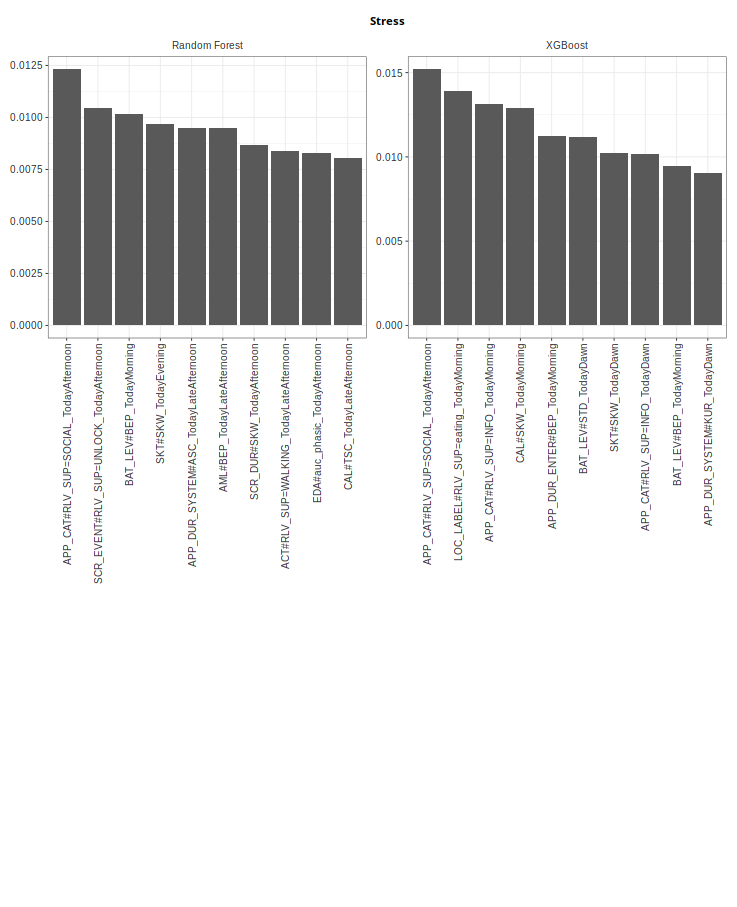

In [27]:
%%R -i IMPORTANCE_SUMMARY -w 26 -h 32 -u cm

plots <- list()

#for (l in c('valence', 'arousal', 'stress', 'disturbance')) {
for (l in c( 'stress')) {
    data <- IMPORTANCE_SUMMARY %>% filter(
        (label == l)
    )

    p_label <- ggplot() + geom_text(
        aes(x=.5, y=.5),
        label=str_to_title(l), 
        family='ssp', 
        fontface='bold',
        size=4
    ) + theme_void()

    p_rf <- ggplot(
        data %>% filter(alg == 'rf_os') %>% top_n(n=10, wt=importance),
        aes(x=reorder(feature, -importance), y=importance),
    ) + geom_col(
    ) + THEME_DEFAULT + theme(
        axis.text.x=element_text(angle=90, size=10, hjust=1, vjust=.5),
        axis.title.x=element_blank(),
        axis.title.y=element_blank()
    ) + labs(
        subtitle='Random Forest'
    )
    
    p_xgb <- ggplot(
        data %>% filter(alg == 'xgb_os') %>% top_n(n=10, wt=importance),
        aes(x=reorder(feature, -importance), y=importance),
    ) + geom_col(
    ) + THEME_DEFAULT + theme(
        axis.text.x=element_text(angle=90, size=10, hjust=1, vjust=.5),
        axis.title.x=element_blank(),
        axis.title.y=element_blank()
    ) + labs(
        subtitle='XGBoost'
    )
    
    plots[[paste(l, 'label', sep='_')]] <- p_label
    plots[[paste(l, 'rf', sep='_')]] <- p_rf
    plots[[paste(l, 'xgb', sep='_')]] <- p_xgb
}

#p <- plots$arousal_label + plots$valence_label
#p <- p / (plots$arousal_rf | plots$arousal_xgb | plots$valence_rf | plots$valence_xgb)
#p <- p / (plots$stress_label + plots$disturbance_label)
#p <- p / (plots$stress_rf | plots$stress_xgb | plots$disturbance_rf | plots$disturbance_xgb)
p <- plots$stress_label 
p <- p / (plots$stress_rf | plots$stress_xgb)

p <- p + plot_layout(
    heights=c(1.1, 10, 1.1, 10)
)

ggsave(paste('./fig/imp.pdf'), plot=p, width=26, height=32, unit='cm', device=cairo_pdf)
print(p)
